First start the session by importing useful libraries and reading the output csv from indeed-job-scraping. Check dataframe

In [54]:
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, MWETokenizer

jobs_df = pd.read_csv('jobs.csv')
print(jobs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  883 non-null    int64 
 1   job_title   883 non-null    object
 2   company     883 non-null    object
 3   salary      883 non-null    object
 4   location    883 non-null    object
 5   date        883 non-null    object
 6   links       883 non-null    object
 7   job_desc    883 non-null    object
dtypes: int64(1), object(7)
memory usage: 55.3+ KB
None


PART 1: Data Cleaning:

First, drop unneccessary columns.
Then, check for empty cells.
Then, check for duplicated values.

In [55]:
jobs_df = jobs_df.drop(jobs_df.columns[[0,4,6]],axis =1)
print(jobs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job_title  883 non-null    object
 1   company    883 non-null    object
 2   salary     883 non-null    object
 3   date       883 non-null    object
 4   job_desc   883 non-null    object
dtypes: object(5)
memory usage: 34.6+ KB
None


In [56]:
print("missing values:", jobs_df.isna().sum())

missing values: job_title    0
company      0
salary       0
date         0
job_desc     0
dtype: int64


In [57]:
print(jobs_df[jobs_df.duplicated()])

                                 job_title                         company  \
203                           Data Analyst  U.S. Bank National Association   
227            Data Analytics Professional     Cogent Infotech Corporation   
306                           Data Analyst  U.S. Bank National Association   
443                           Data Analyst  U.S. Bank National Association   
688  Principal Data Engineer - Telecommute                      Providence   
775                       Sr. Data Analyst       AMA Consulting Group, LLC   

                                      salary                       date  \
203  $74,402 - $146,100 a year Employer est.          PostedJust posted   
227                             Full-time +1  PostedPosted 30+ days ago   
306  $74,402 - $146,100 a year Employer est.          PostedJust posted   
443  $74,402 - $146,100 a year Employer est.          PostedJust posted   
688                                Full-time    PostedPosted 5 days ago   
775

Found a few duplicated rows... delete them

In [58]:
jobs_df=jobs_df.drop_duplicates()
print(jobs_df[jobs_df.duplicated()])

Empty DataFrame
Columns: [job_title, company, salary, date, job_desc]
Index: []


Next step in data cleanup is to clean up the date column.

From indeed we scraped "Job Posted X Days ago" we want to change that into a date_posted column

In [59]:
jobs_df["date"] = jobs_df["date"].str.replace(r"\D", "" , regex = True) # keep only the integer value from how long ago the jo was posted

jobs_df = jobs_df.convert_dtypes() #convert all to optimal types
jobs_df["date"] = pd.to_numeric(jobs_df["date"],errors='coerce') # - convert date to float
jobs_df["date"] = jobs_df["date"].fillna(0) # fill NAs
jobs_df["date"] = pd.to_timedelta(jobs_df["date"], unit="days") # - change date to timedelta

jobs_df.insert(4, "date_posted" ,datetime.now()) # - start a new column with current date
jobs_df["date_posted"] = (jobs_df["date_posted"] - jobs_df["date"]).dt.date # subtract how long ago the job was posted from current date to get the date the job was posted
jobs_df = jobs_df.drop("date", axis = 1) # - drop unneccessary column

Now do some EDA:

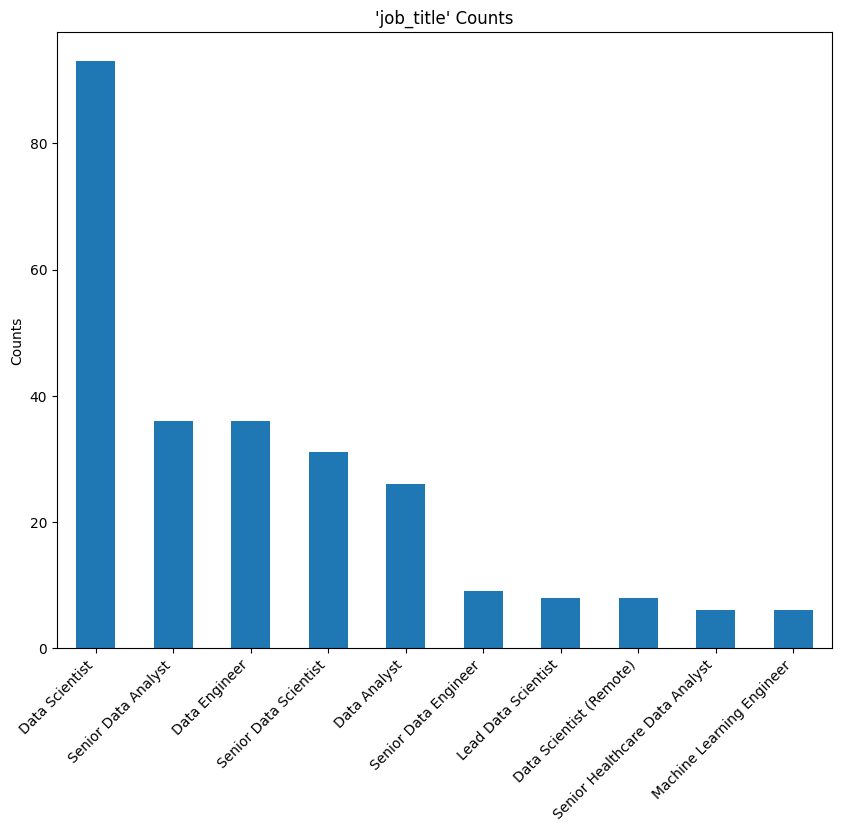

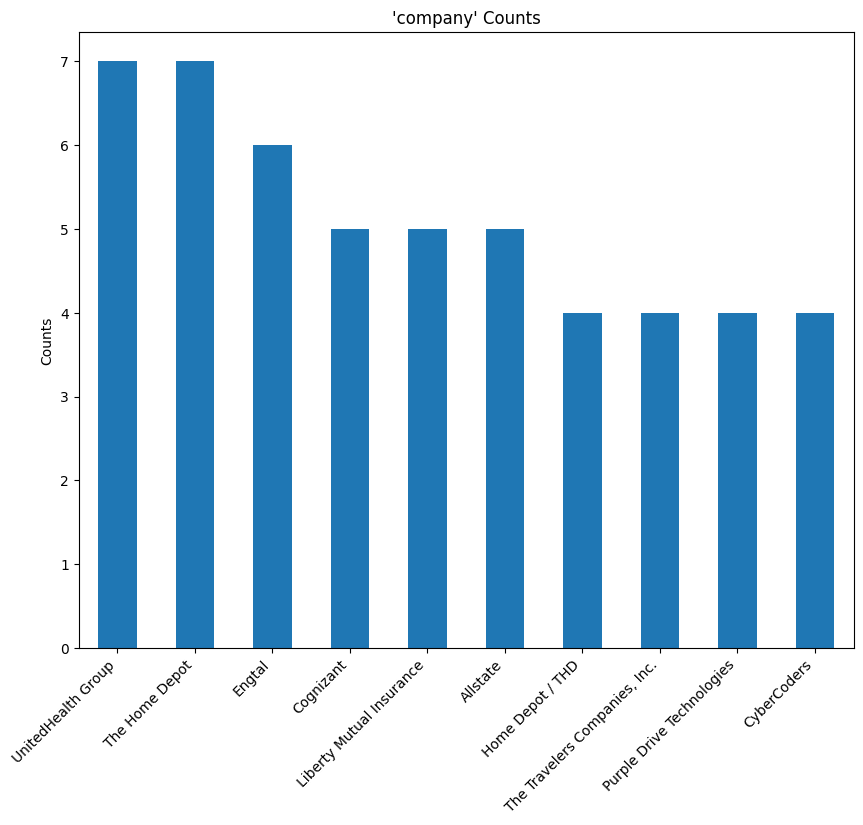

In [60]:
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    jobs_df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' Counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 45, ha='right')
    plt.show()

columns = ['job_title', 'company']

for column in columns:
    eda_plot(column)

Now clean up salary


In [61]:
salary_df = pd.DataFrame() # set a new dataframe 
salary_df["salary"] = jobs_df["salary"] # copy salary column from old df
salary_df[['salarylow','salaryhigh']] = salary_df.salary.str.split(pat="-", expand=True)
salary_df["hourly"] = jobs_df["salary"].str.contains('|'.join(['hour','Hour','HOUR','hourly','hr']), regex = True)

salary_df['salaryhigh'] = salary_df['salaryhigh'].fillna(salary_df['salarylow'])
salary_df.salarylow = salary_df.salarylow.str.extract('\$([0-9,.]+)')
salary_df.salaryhigh = salary_df.salaryhigh.str.extract('\$([0-9,.]+)')

salary_df["salarylow"] = salary_df["salarylow"].str.replace(",", "" , regex = True)
salary_df["salaryhigh"] = salary_df["salaryhigh"].str.replace(",", "" , regex = True)

salary_df.salarylow = pd.to_numeric(salary_df.salarylow).fillna(0)
salary_df.salaryhigh = pd.to_numeric(salary_df.salaryhigh).fillna(0)

salary_df["adjustedsalarylow"] = salary_df["salarylow"]*salary_df["hourly"]*2080
salary_df["adjustedsalaryhigh"] = salary_df["salaryhigh"]*salary_df["hourly"]*2080
salary_df.insert(5,"adjustedsalarymean","")

salary_df["adjustedsalarylow"] = np.maximum(salary_df.adjustedsalarylow, salary_df.salarylow)
salary_df["adjustedsalaryhigh"] = np.maximum(salary_df.adjustedsalaryhigh, salary_df.salaryhigh)
salary_df["adjustedsalarymean"] = salary_df[["adjustedsalaryhigh","adjustedsalarylow"]].mean(axis=1)

jobs_df= jobs_df.drop("salary",axis=1)
salary_df= salary_df.drop("salary",axis=1)
salary_df=salary_df.drop("hourly",axis =1)
salary_df=salary_df.drop("salaryhigh",axis =1)
salary_df=salary_df.drop("salarylow",axis =1)

salary_df = salary_df.where(salary_df>0).dropna().reset_index(drop=True)

print(jobs_df.info(),salary_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 0 to 882
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_title    877 non-null    string
 1   company      877 non-null    string
 2   date_posted  877 non-null    object
 3   job_desc     877 non-null    string
dtypes: object(1), string(3)
memory usage: 34.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adjustedsalarylow   459 non-null    Float64
 1   adjustedsalarymean  459 non-null    float64
 2   adjustedsalaryhigh  459 non-null    Float64
dtypes: Float64(2), float64(1)
memory usage: 11.8 KB
None None


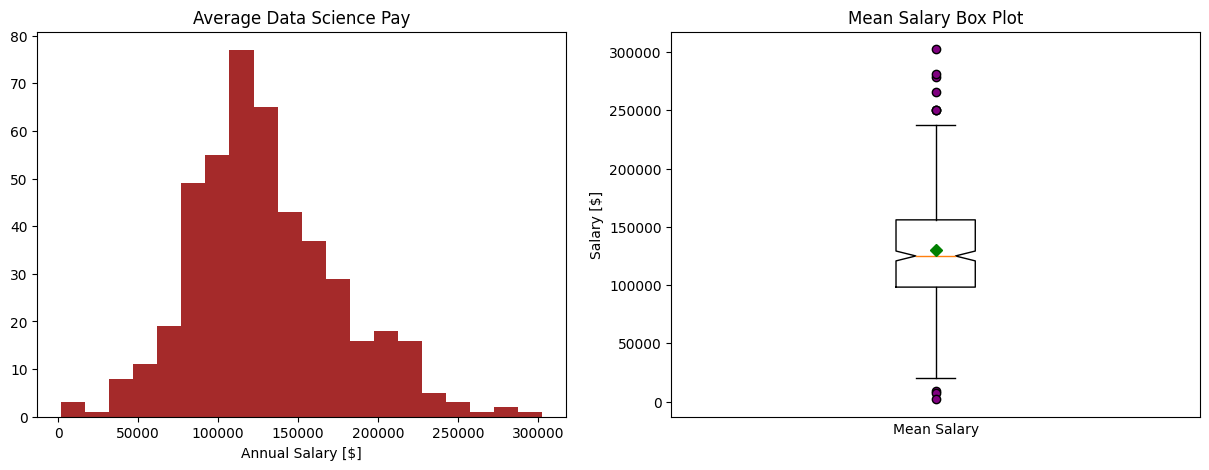

In [62]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].hist(salary_df.adjustedsalarymean, bins = 20, color = 'brown')
axs[0].set_title("Average Data Science Pay")
axs[0].set_xlabel("Annual Salary [$]")
axs[1].set_ylabel("Count")
purple_circle = dict(markerfacecolor='purple', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
axs[1].boxplot(salary_df["adjustedsalarymean"],flierprops=purple_circle,showmeans=True, meanprops=mean_shape, notch=True)
axs[1].set_title("Mean Salary Box Plot")
axs[1].set_ylabel("Salary [$]")
axs[1].set_xlabel('Mean Salary')
axs[1].tick_params(bottom = False, labelbottom = False)
plt.show()

Now that we've done an EDA for salary, job title, and company, lets explore skills. To do this we'll need to do some basic NLP. First pick keywords to look for:

In [63]:
keywords_programming = [
'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js',  'java', 'scala', 'sas', 'matlab', 
'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
'kotlin', 'ruby',  'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
'visual_basic', 'pascal', 'mongo', 'pl/sql',  'sass', 'vb.net', 'mssql', 
]

keywords_libraries = [
'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]

keywords_tools = [
'excel', 'tableau',  'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
'microstrategy',  'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
'docker', 'linux', 'jira',  'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
'linux/unix', 'ubuntu', 'nuix', 'datarobot','npl','dbt','mapreduce','hive','pipeline','pipelines',
'microsoft', 'slack', 'apache', 'ibm', 'html5', 'datadog', 'bloomberg',  'ajax', 'persicope',
'oracle','aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora', 
]

keywords_general = [
'coding', 'server', 'database', 'cloud', 'warehousing', 'scrum', 'devops', 'programming', 'saas', 'ci/cd', 'cicd', 
'ml', 'data_lake', 'frontend',' front-end', 'back-end', 'backend', 'json', 'xml', 'ios', 'kanban', 'nlp',
'iot', 'codebase', 'agile/scrum', 'agile', 'ai/ml', 'ai', 'paas', 'machine_learning', 'macros', 'iaas',
'fullstack', 'dataops', 'scrum/agile', 'ssas', 'mlops', 'debug', 'etl', 'a/b', 'slack', 'erp', 'oop', 
'object-oriented', 'etl/elt', 'elt', 'dashboarding', 'big-data', 'twilio', 'ui/ux', 'ux/ui', 'vlookup','nlp','npl', 
'crossover',  'data_lake', 'data_lakes', 'bi', 'statistics', 'dashboard', 'dashboards','ar','vr','dataops', ' analytics','querying','wrangling',
]

keywords = keywords_programming + keywords_libraries + keywords_tools + keywords_general

Now we need to break job descriptions down into keywords through tokenization

In [64]:
jobs_df['description_tokens'] = "" # Initialize new series (column)
for index, row in jobs_df.iterrows(): #start a for loop using iterrows to iterate through each row in df
    # lowercase words
    detail = row.job_desc.lower() #assigns detail variable to each row's job description in lowercase font
    # tokenize words
    detail = word_tokenize(detail) #breaks each job description down into tokens
    # handle multi-word tokenization (e.g., 'Power BI')
    multi_tokens = [('power', 'bi'), ('data', 'lake'), ('data', 'lakes'), ('machine', 'learning'), ('objective', 'c'),
                    ('visual', 'basic'),('predictive','modeling'),('data','collection'),('requirement','gathering'),('statistical','model'),('big','data')] # sets up multi-word tokens
    tokenizer = MWETokenizer(multi_tokens) #Tokenizer used for multiword expressions, this adds multiword expressions to the tokenizer
    detail = tokenizer.tokenize(detail) # tokenizes keywords with applicable MWEs
    # remove duplicates
    detail = list(set(detail)) # First converts to sets (makes unique) then converts back to list
    # filter for keywords only
    detail = [word for word in detail if word in keywords] 
    # replace duplicate keywords
    replace_tokens = {'powerbi' : 'power_bi', 'spreadsheets': 'spreadsheet'}
    for key, value in replace_tokens.items():
        detail = [d.replace(key, value) for d in detail]
    # add to details list # row.description_tokens = detail
    jobs_df.at[index, 'description_tokens'] = detail

print(jobs_df.description_tokens)
print(jobs_df.info())

0      [sql, hadoop, python, java, programming, matla...
1      [spark, sql, nlp, numpy, pandas, ml, machine_l...
2      [pipelines, programming, r, machine_learning, ...
3      [slack, hadoop, python, programming, aws, clou...
4      [pipelines, sql, dashboards, programming, pipe...
                             ...                        
878    [github, sql, bash, hadoop, python, linux, mac...
879                   [python, html, c, javascript, xml]
880    [pipelines, python, linux, programming, aws, p...
881    [sql, power_bi, tableau, programming, excel, m...
882    [sql, sas, tableau, spreadsheet, programming, ...
Name: description_tokens, Length: 877, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 0 to 882
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           877 non-null    string
 1   company             877 non-null    string
 2   date_posted        

Now that words have been tokenized, we visualize the most common programming languages, libraries, tools, and general keywords for remote data science jobs

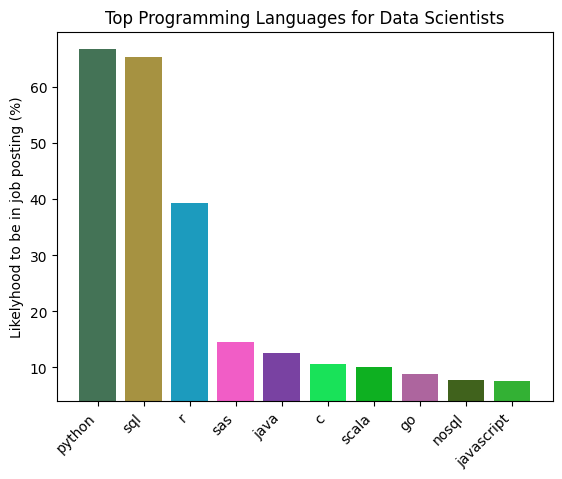

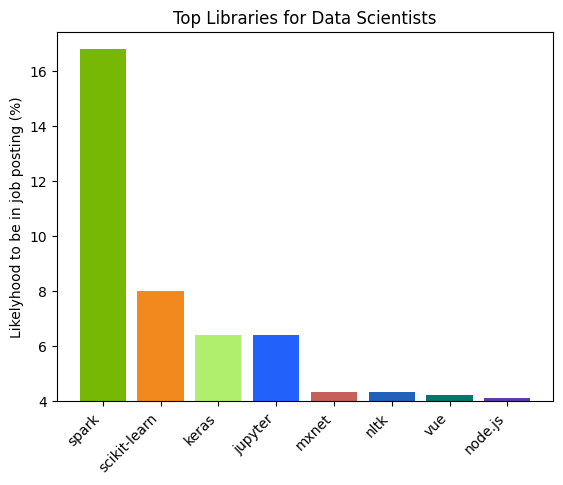

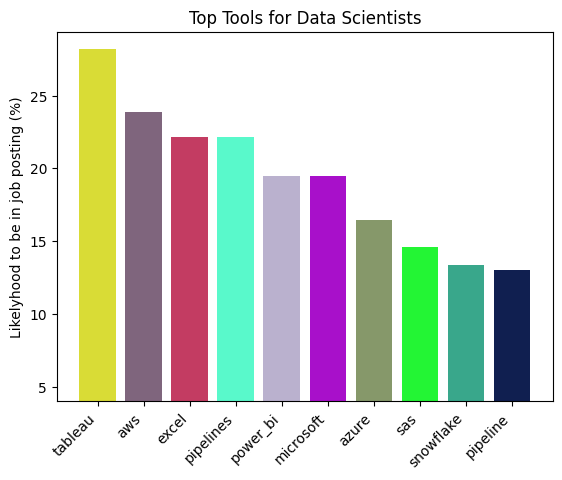

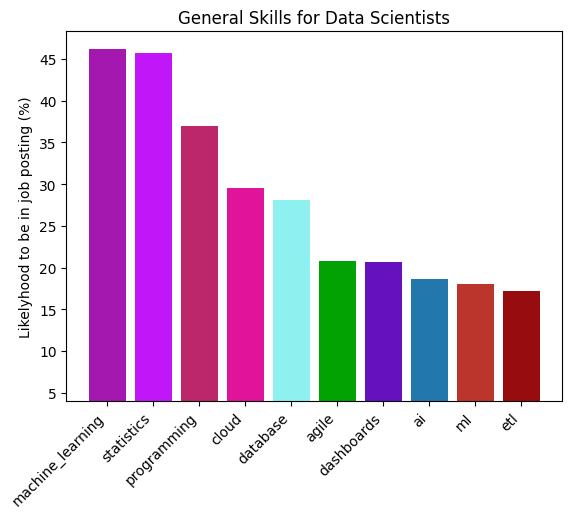

In [65]:
def filtered_keywords(jobs_filtered,keywords,title = "Keyword Analysis", head=10):

    count_keywords = pd.DataFrame(jobs_df.description_tokens.sum())
    count_keywords = count_keywords.value_counts().rename_axis('keywords').reset_index(name='counts')
    count_keywords['percentage'] = 100* (count_keywords.counts/len(jobs_filtered)) # number of job postings
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(head)
    g = plt.bar(x="keywords", height="percentage", bottom = 4, data=count_keywords , color=np.random.rand(len(count_keywords.keywords), 3))
    plt.xlabel("")
    plt.ylabel("Likelyhood to be in job posting (%)")
    plt.xticks(rotation = 45, ha='right')
    plt.title(title)
    plt.show()

filtered_keywords(jobs_df, keywords_programming, title="Top Programming Languages for Data Scientists")
filtered_keywords(jobs_df, keywords_libraries, title="Top Libraries for Data Scientists")
filtered_keywords(jobs_df, keywords_tools, title="Top Tools for Data Scientists")
filtered_keywords(jobs_df, keywords_general, title="General Skills for Data Scientists")

done! This was an exploratory data analysis project using job data scraped from indeed. 

Data cleaning and EDA was adapted from Luke Barrouse's project: https://github.com/lukebarousse/Job_Analysis